## Data Preparpation

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
torch.manual_seed(42)

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 6,  8,  9,  2,  1, 10,  0,  7,  3]), tensor([5, 4]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

## Linear Model

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
print(linear_model(t_un_val))
print(t_un_val)

tensor([[4.4375],
        [5.0807]], grad_fn=<AddmmBackward>)
tensor([[4.8900],
        [5.6300]])


In [6]:
display(linear_model.weight)
print()
display(linear_model.bias)

Parameter containing:
tensor([[0.8692]], requires_grad=True)

Parameter containing:
tensor([0.1872], requires_grad=True)

In [7]:
linear_model.weight*torch.tensor([[4.89], [5.63]]) + linear_model.bias

tensor([[4.4375],
        [5.0807]], grad_fn=<AddBackward0>)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([1.0564], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564],
        [1.0564]], grad_fn=<AddmmBackward>)

## Torch Optimizer

In [10]:
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7f486f2d5bd0>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8692]], requires_grad=True),
 Parameter containing:
 tensor([0.1872], requires_grad=True)]

In [13]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [14]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 116.2615, Validation loss 31.5179
Epoch 1000, Training loss 3.5208, Validation loss 3.8973
Epoch 2000, Training loss 2.9786, Validation loss 3.3753
Epoch 3000, Training loss 2.9693, Validation loss 3.3137

Parameter containing:
tensor([[5.3837]], requires_grad=True)
Parameter containing:
tensor([-17.0656], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 148.1614, Validation loss 52.2259
Epoch 1000, Training loss 3.5068, Validation loss 3.8890
Epoch 2000, Training loss 2.9784, Validation loss 3.3744
Epoch 3000, Training loss 2.9693, Validation loss 3.3136

Parameter containing:
tensor([[5.3838]], requires_grad=True)
Parameter containing:
tensor([-17.0661], requires_grad=True)


## Multi-Layer Model

In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
display(next(seq_model.parameters()))
print()
display(next(seq_model.named_parameters()))

Parameter containing:
tensor([[ 0.7709],
        [ 0.1478],
        [-0.4668],
        [ 0.2549],
        [-0.4607],
        [-0.1173],
        [-0.4062],
        [ 0.6634],
        [-0.7894],
        [-0.4610],
        [-0.2824],
        [-0.6013],
        [ 0.0944]], requires_grad=True)

('0.weight',
 Parameter containing:
 tensor([[ 0.7709],
         [ 0.1478],
         [-0.4668],
         [ 0.2549],
         [-0.4607],
         [-0.1173],
         [-0.4062],
         [ 0.6634],
         [-0.7894],
         [-0.4610],
         [-0.2824],
         [-0.6013],
         [ 0.0944]], requires_grad=True))

In [18]:
print([param.shape for param in seq_model.parameters()])
print()
for name, param in seq_model.named_parameters():
    print(name, param.shape)

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
[param for param in seq_model.parameters()]

[Parameter containing:
 tensor([[ 0.7709],
         [ 0.1478],
         [-0.4668],
         [ 0.2549],
         [-0.4607],
         [-0.1173],
         [-0.4062],
         [ 0.6634],
         [-0.7894],
         [-0.4610],
         [-0.2824],
         [-0.6013],
         [ 0.0944]], requires_grad=True),
 Parameter containing:
 tensor([-0.9877,  0.9031, -0.8495,  0.7720,  0.1664, -0.3247,  0.6179,
          0.1559,  0.8080,  0.1093, -0.3154,  0.2687, -0.2712],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.1167,  0.2476,  0.1603, -0.1212,  0.1601,  0.0496,  0.1408,
          -0.1690, -0.2746, -0.1072, -0.2127,  0.2276,  0.0799]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1149], requires_grad=True)]

In [20]:
from collections import OrderedDict

named_seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

named_seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [21]:
print([param.shape for param in named_seq_model.parameters()])
print()
for name, param in named_seq_model.named_parameters():
    print(name, param.shape)

[torch.Size([8, 1]), torch.Size([8]), torch.Size([1, 8]), torch.Size([1])]

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


[param for param in named_seq_model.parameters()]

In [22]:
print(named_seq_model.output_linear.weight)
print(named_seq_model.output_linear.bias)

Parameter containing:
tensor([[ 0.3402, -0.2918, -0.3507, -0.2766, -0.2378,  0.1432,  0.1266,
          0.2938]], requires_grad=True)
Parameter containing:
tensor([-0.1826], requires_grad=True)


## Using Sequential Model

In [23]:
named_seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

optimizer = optim.SGD(named_seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = named_seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 207.8260, Validation loss 91.6691
Epoch 1000, Training loss 4.7746, Validation loss 3.3609
Epoch 2000, Training loss 4.1779, Validation loss 0.6157
Epoch 3000, Training loss 2.8002, Validation loss 0.5698
Epoch 4000, Training loss 2.2731, Validation loss 0.5986
Epoch 5000, Training loss 2.1183, Validation loss 0.6558


In [24]:
print('output:', named_seq_model(t_un_val).detach())
print()
print('answer:', t_c_val)
print()

print('hidden:', named_seq_model.hidden_linear.weight.grad)
print()
print('hidden:', named_seq_model.hidden_linear.bias.grad)

output: tensor([[ 7.9834],
        [12.8086]])

answer: tensor([[ 8.],
        [11.]])

hidden: tensor([[ 9.0032e+00],
        [-4.6535e-01],
        [ 5.0673e-01],
        [-3.3430e-01],
        [ 1.0106e+01],
        [-1.0897e+01],
        [ 9.9285e-03],
        [ 1.0933e+01]])

hidden: tensor([ 1.5543, -0.0568,  0.0530, -0.0503,  1.6814, -1.7566, -0.0083,
         1.7206])


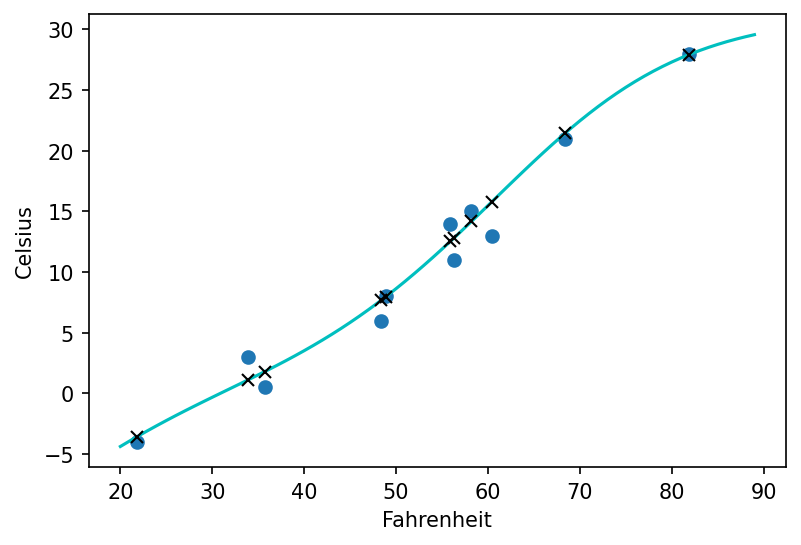

In [25]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), named_seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), named_seq_model(0.1 * t_u).detach().numpy(), 'kx')